# Selecting the Most Efficient Method for a Biological Optimization Problem using Deep Bidirectional Encoder Representations from Transformers (BERT)
Designed to automatically select between deterministic and heuristic methods of solving a biological optimization problem, CutFree, using the BERT unsupervised model architecture.

## Import Dependencies

In [1]:
# system
import os
import csv

# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.metrics import classification_report, confusion_matrix, \
    ConfusionMatrixDisplay

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel, \
    AdamWeightDecay
from numba import cuda

# check device
device = cuda.get_current_device()
device.reset()

## Create Directory Path to Save Model Information

In [2]:
# get previous model version
highest_model_number = 0
for directory in os.listdir("models"):
    model_number = int(directory.split("-V")[-1])
    if model_number >= highest_model_number:
        highest_model_number = model_number + 1

# create save directory
save_folder = "models/AlgorithmClassifier-V" + str(highest_model_number)
save_folder

'models/AlgorithmClassifier-V1'

## Clean Dataset to Include Target

In [3]:
# read in data to dataframe
file_path = "../runtime-simulations/runtime_data.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()

# drop duplicate rows
duplicate_rows = df.duplicated(subset=["Oligo", "Sites"], keep="first")
df = df[~duplicate_rows]

# fix the sites column
df["Sites"] = [s[5:-2] for s in df["Sites"]]
df["Sites"] = [s.replace("\"", "").replace(" ", "") for s in df["Sites"]]
df["Sites"] = [s.split(",") for s in df["Sites"]]

# add time discrepancy column
df["Time_Discrepancy"] = df["CutFree_Time"] - df["CutFreeRL_Time"]

# add correct algorithm column
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]
values = [0, 1] # 0 = CutFree, 1 = CutFreeRL
df["Correct_Algorithm_Choice"] = np.select(conditions, values)

# adjust correct algorithm based on degeneracy if it outside of the confidence 
# interval (i.e., ignore cutfreerl if the degeneracy loss is too significant, 
# typically caused by incomplete cutfreerl output)
df.loc[df["CutFree_Degeneracy"] == 0, "Correct_Algorithm_Choice"] = 1
df.loc[
    df["CutFreeRL_Degeneracy"] <= df["CutFree_Degeneracy"]
    - (df["CutFree_Degeneracy"] * 0.10),
    "Correct_Algorithm_Choice"
] = 0

# count classifcations
print(df["Correct_Algorithm_Choice"].value_counts())

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True).drop(columns=["Unnamed: 0"])

df.head()

Correct_Algorithm_Choice
0    20680
1     6654
Name: count, dtype: int64


,Oligo,Oligo_Length,Sites,Number_of_Sites,Site_Length,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time,Time_Discrepancy,Correct_Algorithm_Choice
0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,39,"[GGNNCC, ACGCGT, TTCGAA, CGTACG]",4,6,NNVHNRNNVWNDVHNDDNHWDDNHNDBHNWBNNYNDBNN,45.421467,19.814023,NHNHHNHYNNYNDBNNTNDNBNKVKNKNDNTNDNBDBDV,43.224242,1.630173,18.183850,1
1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,30,"[RGGNCCY, CCTCAGC, GCTCTTC, ACCWGGT, CACCTGC, ...",10,7,NNNNWNWNWNNNWNWNWNNNNWNWNWNNNN,35.350506,5.664933,NNNNNNANWNDNNDHNAHHNHNHHNWNWHN,34.147662,3.314469,2.350464,1
2,NNNNNNNNNNNNNNN,15,"[CRCCGGYG, RTGCGCAY, GCGGCCGC, GCGATCGC, CGCCG...",6,8,NNNDNNDDNWNNNNN,19.238222,0.044144,NNNNNNDANNNDNBN,18.545075,0.805864,-0.761721,0
3,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,40,"[ACRYGT, CCRYGG, RCCGGY, ATCGAT]",4,6,NDDDDDDDDDDDDDDDDDDDDDDDDDDDDNDBWNDRNNNN,45.147336,60.057122,NNNNNAVHNHHHHNMVMVMNMHNMHNMHNMHNMHNMHNMN,43.106459,1.804925,58.252197,1
4,NNNNNNNNNNNNNNNNNNNNNNNN,24,"[ACCWGGT, CGGWCCG]",2,7,NNNNDHDNNNDHDNNNNHDHNNNN,30.681926,0.017626,NNNNNNMHHHNHNHNHNHNHNHNN,29.988779,0.967599,-0.949972,0


## Get Train, Validation, and Test Data

In [4]:
# gather text and label information for tokenization by concatenating a padded
# version of the restriction sites together and adding the oligo length, number
# of sites, and site length to the end of the string for future reference
texts = []
labels = []
for index, row in df.iterrows():
    temp_text = []
    for site in row["Sites"]:
        if len(site) < 10:
            site = site + " " * (10 - len(site))
        temp_text.append(site)

    if len(temp_text) < 10:
        temp_text += [" " * 10] * (10 - len(temp_text))
        
    oligo_length = row["Oligo_Length"]
    if oligo_length < 10:
        oligo_length = "0" + str(oligo_length)
    temp_text.append(str(oligo_length))

    number_of_sites = row["Number_of_Sites"]
    if number_of_sites < 10:
        number_of_sites = "0" + str(number_of_sites)
    temp_text.append(str(number_of_sites))

    site_length = row["Site_Length"]
    if site_length < 10:
        site_length = "0" + str(site_length)
    temp_text.append(str(site_length))

    texts.append("".join(temp_text))
    labels.append(row["Correct_Algorithm_Choice"])

texts[0], labels[0]

('GGNNCC    ACGCGT    TTCGAA    CGTACG                                                                390406',
 1)

In [5]:
# get random state to improve validity of results
random_state = np.random.randint(0, 1000)

print("Random State: ", random_state)

# create train, validation, and test data for text and lebels
x_train, x_val, y_train, y_val = train_test_split(
    texts, 
    labels, 
    test_size=0.2, 
    random_state=random_state
)
x_val, x_test, y_val, y_test = train_test_split(
    x_val, 
    y_val, 
    test_size=0.5, 
    random_state=random_state
)

print("Train, Val, and Test Sizes: ", len(x_train), len(x_val), len(x_test))

Random State:  198
Train, Val, and Test Sizes:  21867 2733 2734


In [6]:
# extract oligo length, number of sites, and site length from each text
# for the train, validation, and test data
x_train_oligo_lengths = []
x_train_number_of_sites = []
x_train_site_lengths = []
for x in x_train:
    x_train_oligo_lengths.append(int(x[-6:-4]))
    x_train_number_of_sites.append(int(x[-4:-2]))
    x_train_site_lengths.append(int(x[-2:]))

x_val_oligo_lengths = []
x_val_number_of_sites = []
x_val_site_lengths = []
for x in x_val:
    x_val_oligo_lengths.append(int(x[-6:-4]))
    x_val_number_of_sites.append(int(x[-4:-2]))
    x_val_site_lengths.append(int(x[-2:]))

x_test_oligo_lengths = []
x_test_number_of_sites = []
x_test_site_lengths = []
for x in x_test:
    x_test_oligo_lengths.append(int(x[-6:-4]))
    x_test_number_of_sites.append(int(x[-4:-2]))
    x_test_site_lengths.append(int(x[-2:]))

# make tensors for train, val, and test data that contain the oligo length
bert_train_ints = tf.convert_to_tensor(
    (x_train_oligo_lengths)
)

bert_val_ints = tf.convert_to_tensor(
    (x_val_oligo_lengths)
)

bert_test_ints = tf.convert_to_tensor(
    (x_test_oligo_lengths)
)

In [7]:
# drop last 6 characters from each text to remove the oligo length, number of
# sites, and site length and leave only the restriction sites
x_train = [x[:-6] for x in x_train]
x_val = [x[:-6] for x in x_val]
x_test = [x[:-6] for x in x_test]

x_train[0], y_train[0]

('CCTCAGC   CCCWGGG   CGGWCCG   GCTCTTC   GGTNACC   CASTGNN   CCTNAGC   TCCNGGA   CACCTGC   RGGWCCY   ',
 0)

In [8]:
# convert string of sites to list of sites (not required)
x_train_list = []
for x in x_train:
    x_train_temp = []
    for i in range(0, len(x), 10):
        x_train_temp.append(x[i:i+10])
    x_train_list.append(x_train_temp)

x_val_list = []
for x in x_val:
    x_val_temp = []
    for i in range(0, len(x), 10):
        x_val_temp.append(x[i:i+10])
    x_val_list.append(x_val_temp)

x_test_list = []
for x in x_test:
    x_test_temp = []
    for i in range(0, len(x), 10):
        x_test_temp.append(x[i:i+10])
    x_test_list.append(x_test_temp)

## Tokenize Input Sequences

In [9]:
# constants
MAX_LENGTH = 100
BATCH_SIZE = 64
BERT_MODEL_NAME = "distilbert-base-uncased"

# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

# tokenize training data
tokens_train = tokenizer(
    x_train, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

# get input ids and attention masks for training data
input_ids_train = tokens_train["input_ids"]
attention_mask_train = tokens_train["attention_mask"]

# make tensors for training data
texts_train = (input_ids_train, attention_mask_train, bert_train_ints)
labels_train = tf.constant(y_train)
bert_train_dataset = tf.data.Dataset.from_tensor_slices(
    (texts_train, labels_train)
).shuffle(len(labels_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(bert_train_dataset)

# tokenize validation data
tokens_val = tokenizer.batch_encode_plus(
    x_val, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

# get input ids and attention masks for validation data
input_ids_val = tokens_val["input_ids"]
attention_mask_val = tokens_val["attention_mask"]

# make tensors for validation data
texts_val = (input_ids_val, attention_mask_val, bert_val_ints)
labels_val = tf.constant(y_val)
bert_val_dataset = tf.data.Dataset.from_tensor_slices(
    (texts_val, labels_val)
).shuffle(len(labels_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.int32, name=None), TensorSpec(shape=(None, 100), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Create, Compile, Train, and Save Model

In [10]:
# bert input layers
input_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), 
    name="input_ids", 
    dtype="int32"
)
attention_mask = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), 
    name="attention_mask", 
    dtype="int32"
)

# bert model
bert_model = TFDistilBertModel.from_pretrained(
    BERT_MODEL_NAME, 
    output_attentions=False, 
    output_hidden_states=False
)([input_ids, attention_mask])
bert_output = bert_model.last_hidden_state[:, 0, :]

# mlp for head of bert model
bert_mlp = tf.keras.Sequential(
    [
        tf.keras.layers.Dropout(0.5, name="dropout_0_bert"),
        tf.keras.layers.Dense(
            768, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_1_bert"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_1_bert"),
        tf.keras.layers.Dropout(0.4, name="dropout_1_bert"),
        tf.keras.layers.Activation("relu", name="relu_1_bert"),
        tf.keras.layers.Dense(
            128, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_2_bert"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_2_bert"),
        tf.keras.layers.Dropout(0.4, name="dropout_2_bert"),
        tf.keras.layers.Activation("relu", name="relu_2_bert"),
        tf.keras.layers.Dense(
            64, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_3_bert"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_3_bert"),
        tf.keras.layers.Dropout(0.4, name="dropout_3_bert"),
        tf.keras.layers.Activation("relu", name="relu_3_bert")
    ], 
    name="bert_mlp"
)(bert_output)

# oligo length input layer
oligo_length_input = tf.keras.layers.Input(
    shape=(1,),
    name="oligo_length_input",
    dtype="float32"
)

# mlp for oligo length
oligo_length_mlp = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            128, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_1_oligo"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_1_oligo"),
        tf.keras.layers.Dropout(0.4, name="dropout_1_oligo"),
        tf.keras.layers.Activation("relu", name="relu_1_oligo"),
        tf.keras.layers.Dense(
            64, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_2_oligo"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_2_oligo"),
        tf.keras.layers.Dropout(0.4, name="dropout_2_oligo"),
        tf.keras.layers.Activation("relu", name="relu_2_oligo")
    ], 
    name="oligo_length_mlp"
)(oligo_length_input)

# concatenate bert and oligo outputs
concatenate = tf.keras.layers.concatenate(
    [bert_mlp, oligo_length_mlp], 
    name="concatenate"
)

# output layer
output = tf.keras.layers.Dense(
    2, 
    activation="softmax", 
    name="output"
)(concatenate)

# combine input and output layers to create model
model = tf.keras.Model(
    inputs=[input_ids, attention_mask, oligo_length_input], 
    outputs=output, 
    name="BERT_AlgorithmClassifier"
)

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "BERT_AlgorithmClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 100, 768),                                                   
                                 hidden_states=None                        

In [11]:
# create optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# compile model
model.compile(optimizer, loss, metrics=["accuracy"])

# class weights (if not balanced)
class_weights = dict(
    enumerate(
        compute_class_weight(
            class_weight="balanced", 
            classes=np.unique(y_train), 
            y=np.array(y_train)
        )
    )
)

# callbacks for early stopping, saving checkpoints, and tensorboard
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_folder 
        + "/checkpoints/model.{epoch:02d}-{val_accuracy:.3f}.h5"
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_folder + "/checkpoints/best_model.h5",
        monitor='val_accuracy', 
        save_best_only=True
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir=save_folder + "/logs"
    )
]

# fine-tune model to training data
history = model.fit(
    bert_train_dataset,
    validation_data=bert_val_dataset, 
    epochs=100, 
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=model_callbacks
)

Epoch 1/100
342/342 [==============================] - 142s 384ms/step - loss: 23.2062 - accuracy: 0.6248 - val_loss: 20.6414 - val_accuracy: 0.7772
Epoch 2/100
342/342 [==============================] - 131s 382ms/step - loss: 18.7922 - accuracy: 0.7534 - val_loss: 16.4797 - val_accuracy: 0.8438
Epoch 3/100
342/342 [==============================] - 131s 383ms/step - loss: 14.8028 - accuracy: 0.7897 - val_loss: 12.7608 - val_accuracy: 0.8741
Epoch 4/100
342/342 [==============================] - 131s 382ms/step - loss: 11.3922 - accuracy: 0.8190 - val_loss: 9.7352 - val_accuracy: 0.8829
Epoch 5/100
342/342 [==============================] - 130s 381ms/step - loss: 8.7172 - accuracy: 0.8303 - val_loss: 7.4508 - val_accuracy: 0.8917
Epoch 6/100
342/342 [==============================] - 129s 378ms/step - loss: 6.7729 - accuracy: 0.8435 - val_loss: 5.9290 - val_accuracy: 0.8525
Epoch 7/100
342/342 [==============================] - 129s 377ms/step - loss: 5.4133 - accuracy: 0.8533 - val_

In [ ]:
# load tensorboard
%tensorboard --logdir logs

In [12]:
# build an mlp to classify the algorithm based on the oligo length, number of
# sites, and site length as a comparison metric for the bert model
mlp_inputs = tf.keras.Input(
    shape=(3,),
    name="mlp_inputs",
    dtype="float32"
)

mlp = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            128, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_1_mlp"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_1_mlp"),
        tf.keras.layers.Dropout(0.4, name="dropout_1_mlp"),
        tf.keras.layers.Activation("relu", name="relu_1_mlp"),
        tf.keras.layers.Dense(
            64, 
            kernel_regularizer = tf.keras.regularizers.L1L2(1e-3),
            bias_regularizer = tf.keras.regularizers.L1L2(1e-3),
            activity_regularizer = tf.keras.regularizers.L1L2(1e-3),
            name="dense_2_mlp"
        ),
        tf.keras.layers.BatchNormalization(name="batch_norm_2_mlp"),
        tf.keras.layers.Dropout(0.4, name="dropout_2_mlp"),
        tf.keras.layers.Activation("relu", name="relu_2_mlp")
    ], 
    name="mlp"
)(mlp_inputs)

mlp_outputs = tf.keras.layers.Dense(
    2,
    activation="softmax",
    name="mlp_outputs"
)(mlp)

mlp_model = tf.keras.Model(
    inputs=mlp_inputs,
    outputs=mlp_outputs,
    name="MLP_AlgorithmClassifier"
)

# create optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# compile model
mlp_model.compile(optimizer, loss, metrics=["accuracy"])

# class weights (if not balanced)
class_weights = dict(
    enumerate(
        compute_class_weight(
            class_weight="balanced", 
            classes=np.unique(y_train), 
            y=np.array(y_train)
        )
    )
)

# callbacks for early stopping, saving checkpoints, and tensorboard
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

# make tensors for train and validation data that contain the oligo length, 
# number of sites, and site length
tf_train_mlp = tf.transpose(
    tf.convert_to_tensor(
        (x_train_oligo_lengths, x_train_number_of_sites, x_train_site_lengths)
    )
)
tf_val_mlp = tf.transpose(
    tf.convert_to_tensor(
        (x_val_oligo_lengths, x_val_number_of_sites, x_val_site_lengths)
    )
)

# make tensors for training and validation data
mlp_train_dataset = tf.data.Dataset.from_tensor_slices(
    (tf_train_mlp, labels_train)
).shuffle(len(labels_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
mlp_val_dataset = tf.data.Dataset.from_tensor_slices(
    (tf_val_mlp, labels_val)
).shuffle(len(labels_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# fit model to training data
mlp_history = mlp_model.fit(
    mlp_train_dataset,
    validation_data=mlp_val_dataset, 
    epochs=100, 
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=model_callbacks
)

Epoch 1/100
342/342 [==============================] - 3s 6ms/step - loss: 1.7671 - accuracy: 0.6121 - val_loss: 1.6061 - val_accuracy: 0.7172
Epoch 2/100
342/342 [==============================] - 2s 6ms/step - loss: 1.6034 - accuracy: 0.6961 - val_loss: 1.4778 - val_accuracy: 0.7464
Epoch 3/100
342/342 [==============================] - 2s 6ms/step - loss: 1.5140 - accuracy: 0.7184 - val_loss: 1.3984 - val_accuracy: 0.7508
Epoch 4/100
342/342 [==============================] - 2s 6ms/step - loss: 1.4450 - accuracy: 0.7240 - val_loss: 1.3394 - val_accuracy: 0.7483
Epoch 5/100
342/342 [==============================] - 2s 6ms/step - loss: 1.3758 - accuracy: 0.7301 - val_loss: 1.2745 - val_accuracy: 0.7483
Epoch 6/100
342/342 [==============================] - 2s 6ms/step - loss: 1.3149 - accuracy: 0.7350 - val_loss: 1.2204 - val_accuracy: 0.7472
Epoch 7/100
342/342 [==============================] - 2s 6ms/step - loss: 1.2609 - accuracy: 0.7380 - val_loss: 1.1749 - val_accuracy: 0.7505

## Evaluate BERT Model Performance

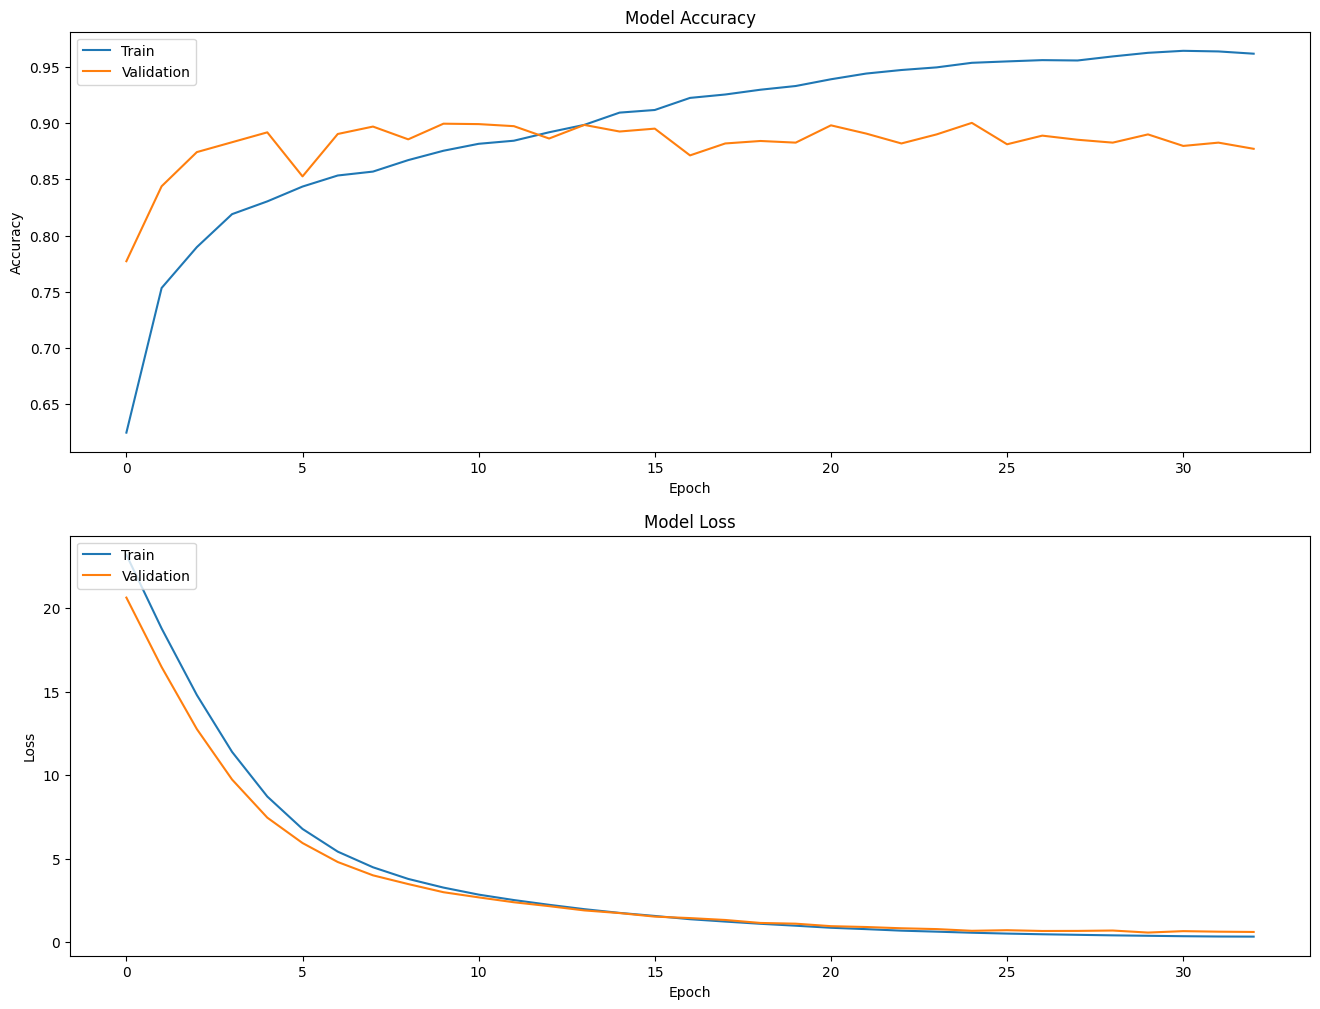

In [13]:
fig = plt.figure(figsize=(16, 12))

# create accuracy plot
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# create loss plot
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# save figure
fig.savefig(save_folder + "/training.png")

In [14]:
# tokenize test data
tokens_test = tokenizer.batch_encode_plus(
    x_test, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

# get input ids and attention masks for test data
input_ids_test = tokens_test["input_ids"]
attention_mask_test = tokens_test["attention_mask"]

# make tensors for test data
texts_test = (input_ids_test, attention_mask_test, bert_test_ints)
labels_test = tf.constant(y_test)
bert_test_dataset = tf.data.Dataset.from_tensor_slices(
    (texts_test, labels_test)
).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# make tensors for mlp test data
tf_test_mlp = tf.transpose(
    tf.convert_to_tensor(
        (x_test_oligo_lengths, x_test_number_of_sites, x_test_site_lengths)
    )
)
mlp_test_dataset = tf.data.Dataset.from_tensor_slices(
    (tf_test_mlp, labels_test)
).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# get accuracy of bert-based model
_, acc = model.evaluate(bert_test_dataset)

# get accuracy of mlp-based model
_, mlp_acc = mlp_model.evaluate(mlp_test_dataset)

# compare performance of bert-based model to mlp-based model
print("BERT Model Accuracy: ", acc)
print("MLP Model Accuracy: ", mlp_acc)

43/43 [==============================] - 0s 3ms/step - loss: 0.5024 - accuracy: 0.7290
BERT Model Accuracy:  0.8701536059379578
MLP Model Accuracy:  0.7289685606956482


In [16]:
# load model
model = tf.keras.models.load_model(
    save_folder + "/checkpoints/best_model.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# get accuracy of best bert-based model
_, acc = model.evaluate(bert_test_dataset)

print("Best BERT Model Accuracy: ", acc)

# save accuracy
with open(save_folder + "/accuracy_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([acc])

43/43 [==============================] - 7s 125ms/step - loss: 0.6767 - accuracy: 0.8961
Best BERT Model Accuracy:  0.8961228728294373


In [17]:
# retrieve model predictions on test data
y_pred = model.predict(texts_test)
y_pred = np.argmax(y_pred, axis=1)

# create classification report
class_report = classification_report(
    y_pred, 
    y_test, 
    target_names=["CutFree", "CutFreeRL"]
)

# save classification report
with open(save_folder + "/classification_report.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([class_report])
    
print(class_report)

86/86 [==============================] - 7s 68ms/step
              precision    recall  f1-score   support

     CutFree       0.93      0.93      0.93      2096
   CutFreeRL       0.78      0.78      0.78       638

    accuracy                           0.90      2734
   macro avg       0.85      0.85      0.85      2734
weighted avg       0.90      0.90      0.90      2734



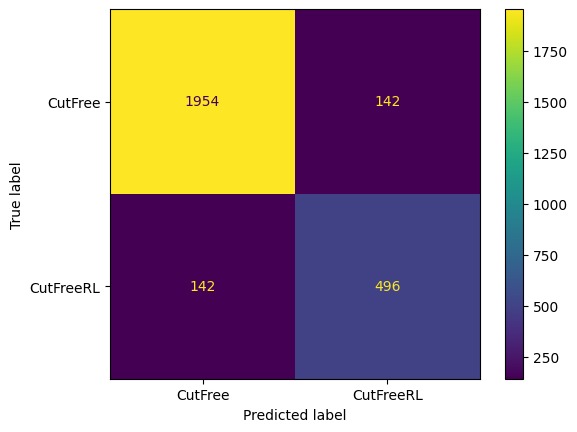

In [18]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=["CutFree", "CutFreeRL"])
fig.plot()

# save confusion matrix
plt.savefig(save_folder + "/confusion_matrix.png")

## Plot Correct Selection for CutFree and CutFreeRL

In [19]:
# sort dataframe by time discrepancy
df = df.sort_values(by=["Time_Discrepancy"]).reset_index(drop=True)

In [20]:
# set colors and font for plots
rgb = []
for _ in df[df["Correct_Algorithm_Choice"] == 0].index:
    c = [46/255, 108/255, 190/255]
    rgb.append(c)

rgb2 = []
for _ in df[df["Correct_Algorithm_Choice"] == 1].index:
    c = [220/255, 77/255, 58/255]
    rgb2.append(c)

gfont = {"fontname": "Georgia"}
font = font_manager.FontProperties(family="Georgia", style="normal", size=32)

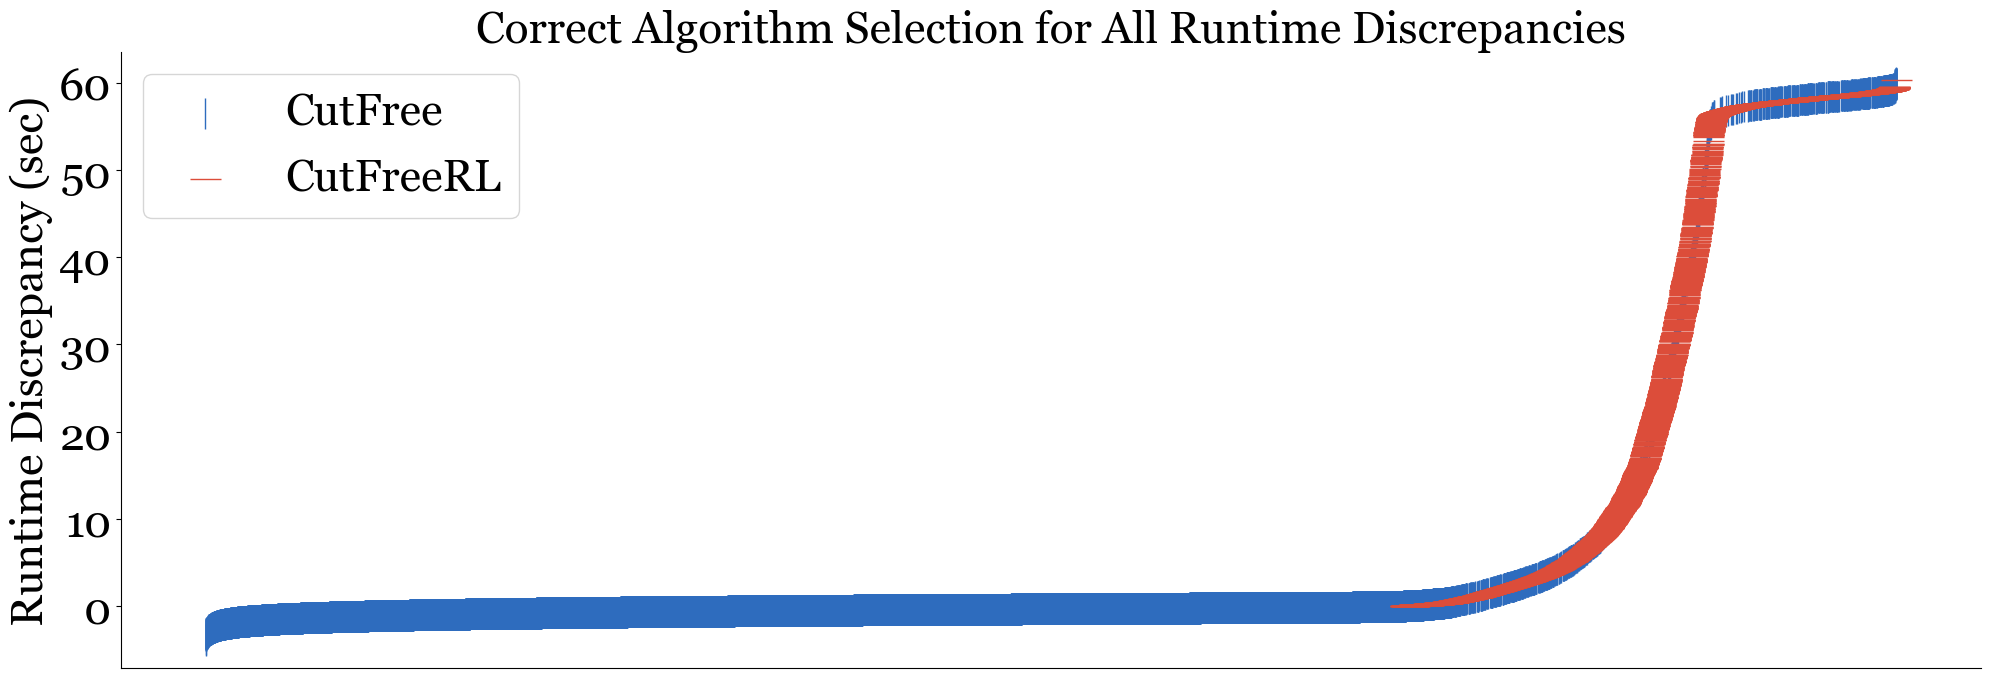

In [29]:
plt.figure(figsize=(24, 8))

# plot expected algorithm selection for all time discrepancies
plt.scatter(
    df[df["Correct_Algorithm_Choice"] == 0].index, 
    df[df["Correct_Algorithm_Choice"] == 0]["Time_Discrepancy"], 
    c=rgb,
    linewidths=1,
    marker="|",
    s=500
)
plt.scatter(
    df[df["Correct_Algorithm_Choice"] == 1].index, 
    df[df["Correct_Algorithm_Choice"] == 1]["Time_Discrepancy"], 
    c=rgb2,
    linewidths=1,
    marker="_",
    s=500
)
    
# set labels
plt.title(
    "Correct Algorithm Selection for All Runtime Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel(
    "Runtime Discrepancy (sec)", 
    fontsize=32, 
    **gfont
)
plt.legend(
    ["CutFree", "CutFreeRL"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save figure
plt.savefig(save_folder + "/correct_algorithm_selection.png")

## Plot Predictions for Selection of CutFree and CutFreeRL

In [30]:
# organize test data for analysis
x_test = np.array(x_test)

# get oligos from test inputs
x_test_oligos = ["N" * x for x in x_test_oligo_lengths]

# get sites from test inputs
x_test_sites = []
for x in x_test:
    temp_sites = [x[i:i+10] for i in range(0, 100, 10)]
    temp_sites = [s.replace(" ", "") for s in temp_sites]
    temp_sites = list(filter(None, temp_sites))
    x_test_sites.append(temp_sites)

print(len(x_test_oligos), len(x_test_sites), len(y_test))

2734 2734 2734


In [31]:
# copy dataframe
df_test = df.copy()

# add prediction column using test data
for oligo, site, pred, test in zip(x_test_oligos, x_test_sites, y_pred, y_test):
    for index, (oligo_df, sites_df) in \
        enumerate(zip(df_test["Oligo"].values, df_test["Sites"].values)):
        if (oligo == oligo_df) and (site == sites_df):
            df_test.loc[index, "Prediction"] = pred == test

# drop unassigned rows
df_test = df_test.dropna(subset=["Prediction"])

# set prediction algorithm
cutfree_condition = \
    ((df_test["Prediction"] == True) \
        & (df_test["Correct_Algorithm_Choice"] == 0)) \
        | ((df_test["Prediction"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 1))
cutfreerl_condition = \
    ((df_test["Prediction"] == True) \
        & (df_test["Correct_Algorithm_Choice"] == 1)) \
        | ((df_test["Prediction"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 0))
df_test.loc[cutfree_condition, "Prediction"] = 0
df_test.loc[cutfreerl_condition, "Prediction"] = 1

# create correct/incorrect column
df_test["Correct"] = \
    df_test["Correct_Algorithm_Choice"] == df_test["Prediction"]

# sort dataframe by discrepancy and reset index
df_test = df_test.sort_values(
    by=["Time_Discrepancy"], 
    ascending=True
).reset_index(drop=True)

# check prediction column
df_test["Prediction"].value_counts() # 0 = CutFree, 1 = CutFreeRL

Prediction
0    2096
1     638
Name: count, dtype: int64

C:\Users\wrick\AppData\Local\Temp\ipykernel_18944\419002027.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


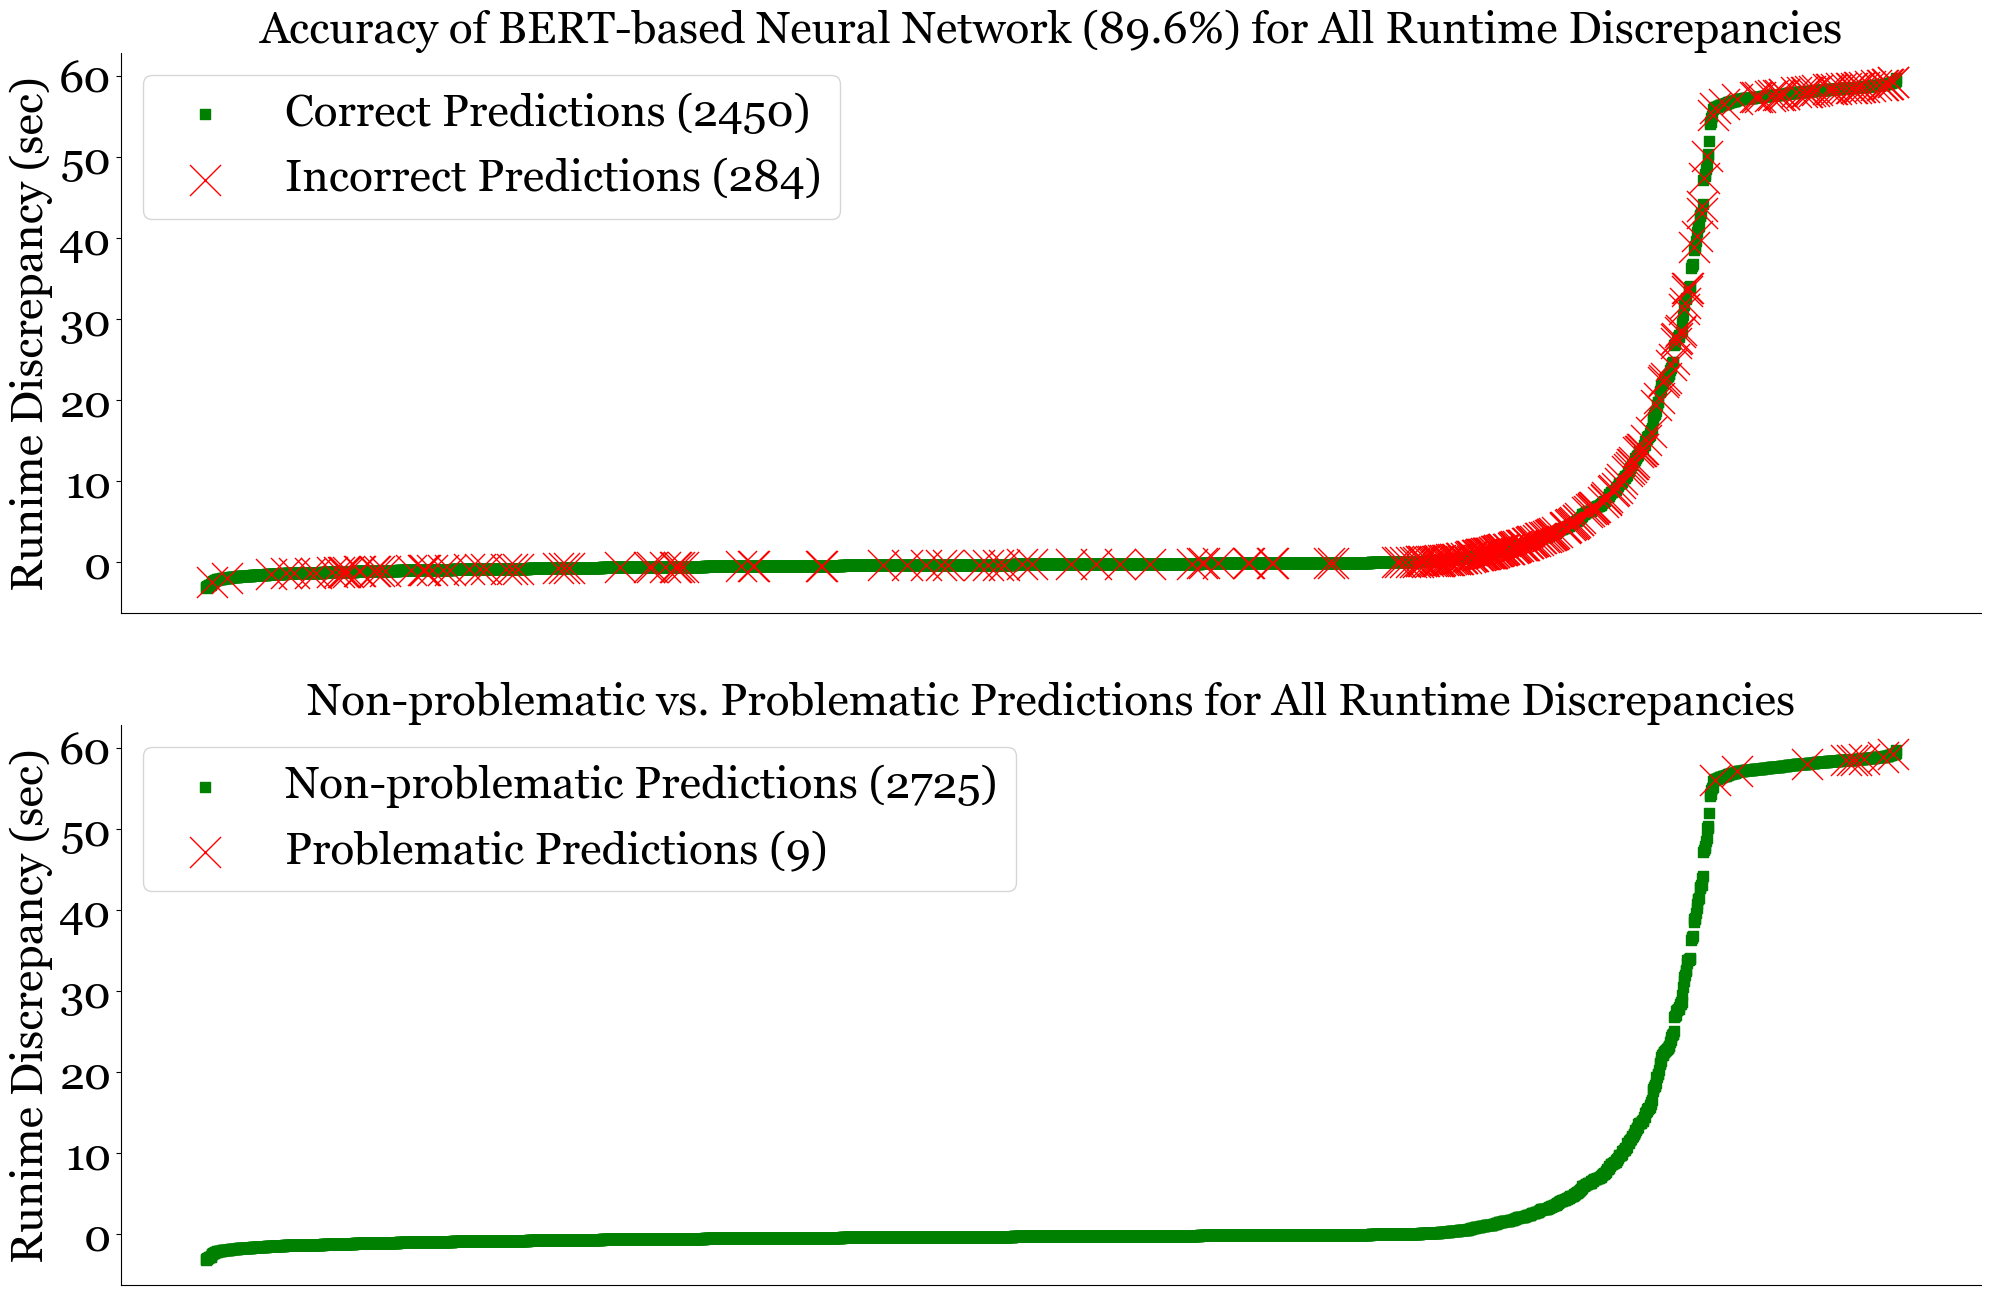

In [42]:
fig, ax = plt.subplots(figsize=(24, 16))

# plot correct and incorrect selections for all time discrepancies
plt.subplot(2, 1, 1)

correct_conditions = (df_test["Correct"] == True)
plt.scatter(
    df_test[correct_conditions].index,
    df_test.loc[correct_conditions, "Time_Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50
)

incorrect_conditions = (df_test["Correct"] == False)
plt.scatter(
    df_test[incorrect_conditions].index,
    df_test.loc[incorrect_conditions, "Time_Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500
)

# set labels
plt.title(
    f"Accuracy of BERT-based Neural Network ({acc * 100:.1f}%) for"
    + " All Runtime Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel("Runime Discrepancy (sec)", fontsize=32, **gfont)
plt.legend(
    [f"Correct Predictions ({len(df_test[correct_conditions])})", 
    f"Incorrect Predictions ({len(df_test[incorrect_conditions])})"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plot problematic and nonproblematic selections for all time discrepancies
plt.subplot(2, 1, 2)

nonproblematic_conditions = (
    (df_test["Correct"] == True) \
        | ((df_test["Correct"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 0)) \
        | ((df_test["Correct"] == False) \
        & (df_test["CutFree_Time"] <= 60))
)
plt.scatter(
    df_test[nonproblematic_conditions].index,
    df_test.loc[nonproblematic_conditions, "Time_Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50
)

# problematic conditions are defined as incorrect predictions that place the 
# system at risk of runtime explosion
problematic_conditions = (
    (df_test["Correct"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 1) \
        & (df_test["CutFree_Time"] >= 60)
)
plt.scatter(
    df_test[problematic_conditions].index,
    df_test.loc[problematic_conditions, "Time_Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500
)

# set labels
plt.title(
    f"Non-problematic vs. Problematic Predictions for All Runtime"
    + " Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel(
    "Runime Discrepancy (sec)", 
    fontsize=32, 
    **gfont
)
plt.legend(
    [f"Non-problematic Predictions ({len(df_test[nonproblematic_conditions])})", 
    f"Problematic Predictions ({len(df_test[problematic_conditions])})"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save figure
plt.savefig(save_folder + "/runtime_discrepancies.png")

In [43]:
# get sensitivity for values above runtime limit
sensitivity = (
    len(df_test[nonproblematic_conditions])) \
        / (len(df_test[nonproblematic_conditions]) \
        + len(df_test[problematic_conditions])
) * 100

# save sensitivity
with open(save_folder + "/sensitivity_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])
    
sensitivity

99.67081199707388

## Get Average Model Statistics

In [44]:
# initialize values
average_sensitivity = np.array([])
average_acc = np.array([])

# retrieve all values from saved CSV files
for directory in os.listdir("models"):
    if directory.startswith("AlgorithmClassifier"):
        with open("models/" + directory + "/sensitivity_results.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_sensitivity = np.append(
                        average_sensitivity, float(row[0])
                    )
        with open("models/" + directory + "/accuracy_results.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_acc = np.append(average_acc, float(row[0]))
        n = len(average_sensitivity)

print(
    f"Average Sensitivity: {average_sensitivity.mean():.1f}% \
        +/- {average_sensitivity.std():.3f}"
)
print(
    f"Average Accuracy: {average_acc.mean() * 100:.1f}% \
        +/- {average_acc.std() * 100:.3f}"
)
print(f"Number of Trials: {n}")

Average Sensitivity: 99.8%         +/- 0.128
Average Accuracy: 90.0%         +/- 0.347
Number of Trials: 2


# Load Model and Make New Predictions

In [45]:
# import dependencies
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay

# load model
best_model = tf.keras.models.load_model(
    save_folder + "/checkpoints/best_model.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# load tokenizer
new_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

best_model.evaluate(texts_test, labels_test)

86/86 [==============================] - 8s 70ms/step - loss: 0.6767 - accuracy: 0.8961


[0.6766592264175415, 0.8961228728294373]

In [46]:
# get input
text_1 = "AGCT GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_2 = "CNNR GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_attributes = tf.transpose(
    tf.convert_to_tensor(
        ([15, 40, 15, 40])
    )
)

new_tokens_test = new_tokenizer.batch_encode_plus(
    [text_1, text_1, text_2, text_2], 
    padding="max_length",
    truncation=True,
    max_length=100,
    return_tensors="tf"
)

new_input_ids_test = new_tokens_test["input_ids"]
new_attention_mask_test = new_tokens_test["attention_mask"]

new_texts_test = (new_input_ids_test, new_attention_mask_test, text_attributes)

# predict
new_y_pred = np.argmax(best_model.predict(new_texts_test), axis=1)

print(
    "Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL): ", new_y_pred
)

1/1 [==============================] - 2s 2s/step
Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL):  [0 1 0 0]
